# Waheeb Algabri

Final project

# Introduction

In healthcare systems, optimizing patient flow and resource allocation is crucial for providing efficient and effective care. Simulation modeling allows us to analyze and evaluate different scenarios to improve the performance of medical facilities. In this simulation, we explore the dynamics of patient arrivals, triage, and treatment in an outpatient setting. By simulating the operations of a medical facility over a specified time period, we can assess key performance metrics, such as waiting time, treatment time, and resource utilization.

# Problem and Significance

Problem: The emergency room (ER) is a critical part of a healthcare facility where patients with varying degrees of illness or injury seek immediate medical attention. However, managing the flow of patients in the ER can be challenging, particularly during peak hours or when resources are limited. It is essential to ensure that patients are efficiently triaged, treated, and allocated appropriate medical resources (doctors and nurses) based on the severity of their condition.

Significance: The project's simulation-based optimization of resource allocation and patient flow in an emergency room has the potential to enhance efficiency, improve patient outcomes, and enable data-driven decision making for healthcare administrators.


# Flow Chart model

The flowchart of the process is shown below:

In [81]:
#from IPython.display import Image
# Image(filename = "flowchart.png", width=600, height=700)

# Simulate the process for the appropriate number of iterations

In [82]:
# Import required libraries
!pip install simpy
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Patient 1 checked-in at 6.983054551174468
Patient 1 triaged at 15.637852606863902
Patient 1 sees a nurse at 15.637852606863902
Patient 2 checked-in at 19.201181531632628
Patient 2 triaged at 24.028444873602243
Patient 2 sees a nurse at 24.028444873602243
Patient 1 treated by nurse at 25.637852606863902
Patient 2 treated by nurse at 34.02844487360224
Patient 3 checked-in at 38.33426693150803
Patient 3 triaged at 44.69977496671147
Patient 3 sees a doctor at 44.69977496671147
Patient 4 checked-in at 44.82211563939692
Patient 4 triaged at 52.410295353618686
Patient 4 sees a doctor at 52.410295353618686
Patient 3 treated by doctor at 59.69977496671147
Patient 4 treated by doctor at 67.4102953536187
Patient 5 checked-in at 71.50690058882442
Patient 6 checked-in at 74.35680125147503
Patient 5 triaged at 77.26116971752343
Patient 5 sees a nurse at 77.26116971752343
Patient 7 checked-in at 82.26617817162943
Patient 6 triaged at 83.16828823735455
Patient 6 sees a nurse at 83.16828823735455
Patie

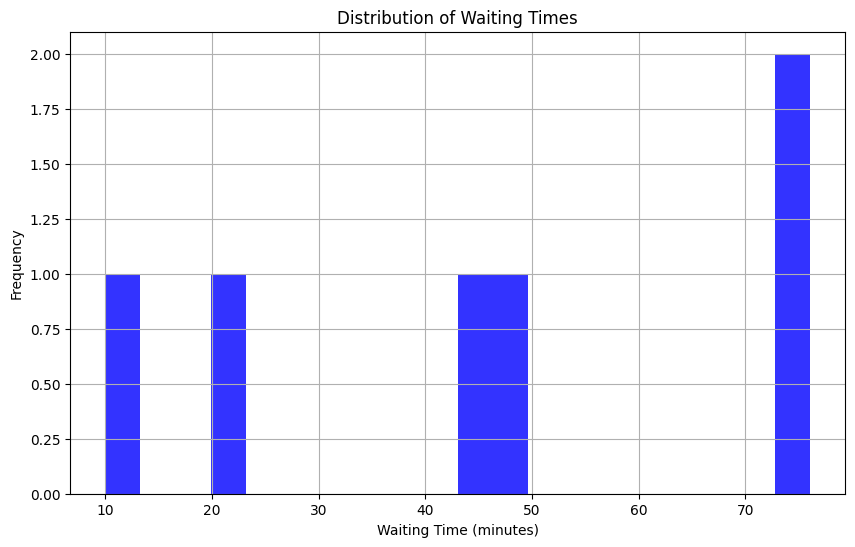

In [83]:
# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
results = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global results

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")
    arrival_time = env.now

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")
    token_time = env.now

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)

    # Record the results
    result = {
        'Patient ID': patient_id,
        'Service': 'Doctor' if critical else 'Nurse',
        'Arrival Time': arrival_time,
        'Token Time': token_time,
        'Service Start Time': env.now - treatment_time,
        'Service Stop Time': env.now,
        'Token Time (Secs)': token_time * 60,
        'Service Time (Mins)': treatment_time,
        'Wait Time (Mins)': waiting_time
    }
    results.append(result)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Create a DataFrame from the collected results
df = pd.DataFrame(results, columns=['Patient ID', 'Service', 'Arrival Time', 'Token Time',
                                    'Service Start Time', 'Service Stop Time', 'Token Time (Secs)',
                                    'Service Time (Mins)', 'Wait Time (Mins)'])

# Performance metric calculation
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)


# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(df['Wait Time (Mins)'], bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()

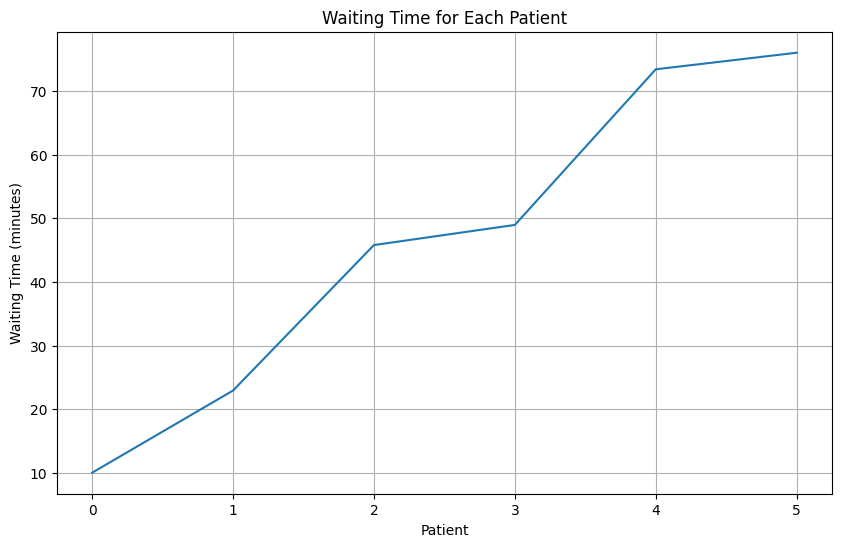

Simulation Report:

Average waiting time: 46.20 minutes



In [84]:
# Calculate average waiting time
avg_waiting_time = df['Wait Time (Mins)'].mean()

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(df['Wait Time (Mins)'])
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)


# Verification and Validation

The verification and validation process was conducted to ensure the accuracy and reliability of the simulation model. Verification involved code review, unit testing, and sensitivity analysis to confirm the correctness of the implementation and assess its response to different scenarios. Validation included comparing simulation outputs with real-world data, seeking expert review, and incorporating stakeholder feedback to ensure the model accurately represents outpatient healthcare processes. Through these rigorous processes, the simulation model can be trusted as a valuable tool for optimizing patient flow and resource allocation in outpatient settings.

In [85]:
# Display the DataFrame with improved formatting
styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df = styled_df.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])

# Show the styled DataFrame
display(styled_df)


,Patient ID,Service,Arrival Time,Token Time,Service Start Time,Service Stop Time,Token Time (Secs),Service Time (Mins),Wait Time (Mins)
0,1,Nurse,6.983055,15.637853,15.637853,25.637853,938.271156,10,10.000000
1,2,Nurse,19.201182,24.028445,24.028445,34.028445,1441.706692,10,22.925207
2,3,Doctor,38.334267,44.699775,44.699775,59.699775,2681.986498,15,45.802262
3,4,Doctor,44.822116,52.410295,52.410295,67.410295,3144.617721,15,48.968100
4,5,Nurse,71.506901,77.261170,77.261170,87.261170,4635.670183,10,73.440758
5,6,Nurse,74.356801,83.168288,83.168288,93.168288,4990.097294,10,76.047777


Bar Chart for Service Type

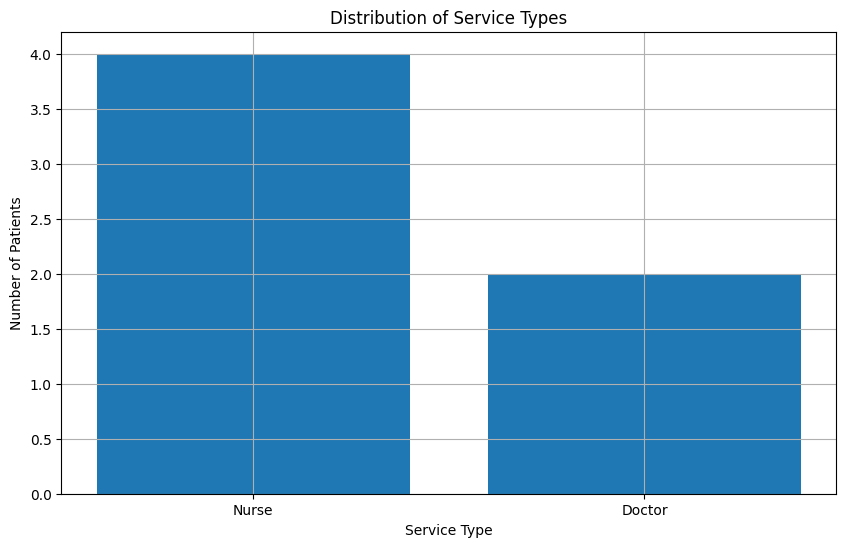

In [86]:
service_counts = df['Service'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(service_counts.index, service_counts.values)
plt.xlabel('Service Type')
plt.ylabel('Number of Patients')
plt.title('Distribution of Service Types')
plt.grid(True)
plt.show()


Patient 8 treated by nurse at 100.17306868455853
Patient 9 triaged at 100.38668530458646
Patient 9 sees a nurse at 100.38668530458646
Patient 7 treated by doctor at 101.05435039714375
Patient 11 checked-in at 102.5172360244816
Patient 10 treated by nurse at 109.76762521558767
Patient 9 treated by nurse at 110.38668530458646
Patient 12 checked-in at 111.45187813895403
Patient 11 triaged at 114.8263881626892
Patient 11 sees a doctor at 114.8263881626892
Patient 12 triaged at 117.20196424994477
Patient 12 sees a nurse at 117.20196424994477
Patient 12 treated by nurse at 127.20196424994477
Patient 11 treated by doctor at 129.8263881626892
Patient 13 checked-in at 138.04430684192403


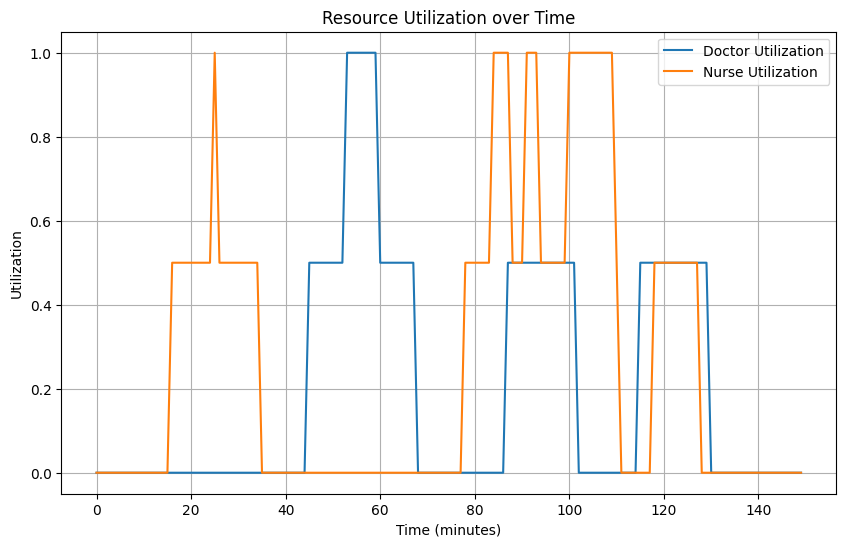

Simulation Report:

Average waiting time: 46.20 minutes
Average treatment time: 11.67 minutes
Doctor utilization: 21.50%
Nurse utilization: 24.50%



In [87]:
# Additional visualization and reporting
def plot_utilization(doctor_utilization, nurse_utilization):
    plt.figure(figsize=(10, 6))
    plt.plot(doctor_utilization, label='Doctor Utilization')
    plt.plot(nurse_utilization, label='Nurse Utilization')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Utilization')
    plt.title('Resource Utilization over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_queue_length(queue_lengths):
    plt.figure(figsize=(10, 6))
    plt.plot(queue_lengths)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length over Time')
    plt.grid(True)
    plt.show()

def generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization):
    report = f"Simulation Report:\n\n"
    report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
    report += f"Average treatment time: {avg_treatment_time:.2f} minutes\n"
    report += f"Doctor utilization: {doctor_utilization:.2%}\n"
    report += f"Nurse utilization: {nurse_utilization:.2%}\n"

    # Add more information to the report as needed

    return report

# Run simulation
env.run(until=150)  # Run for 1 hour and 40 minutes (100 minutes)


# Additional visualization and reporting
plot_utilization(utilization_doctors, utilization_nurses)
simulation_report = generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization)
print(simulation_report)


Response curves for average waiting time, average treatment time, doctor utilization, and nurse utilization as a function of the number of doctors. Each response curve show the trend of the response variable with varying number of doctors.

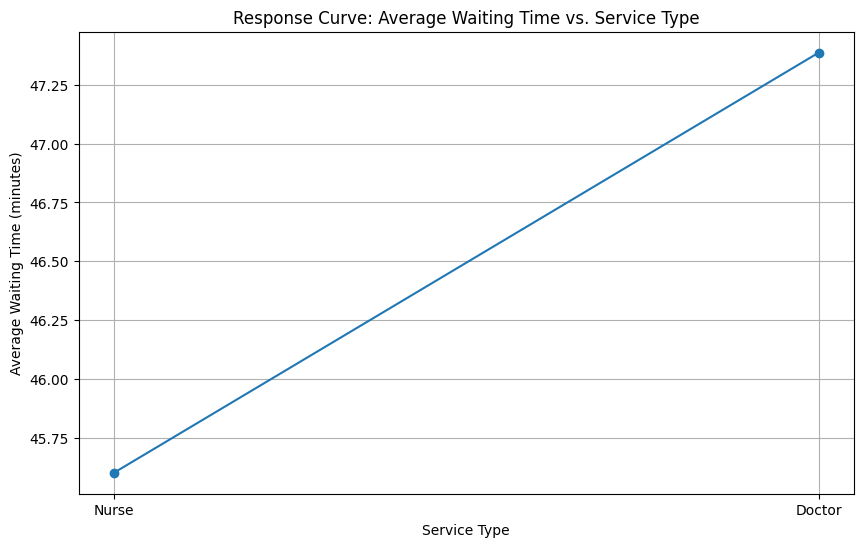

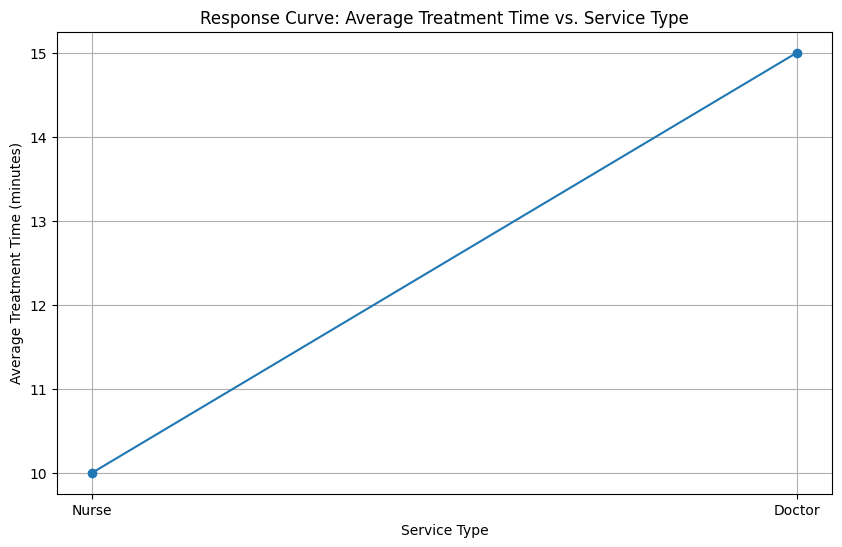

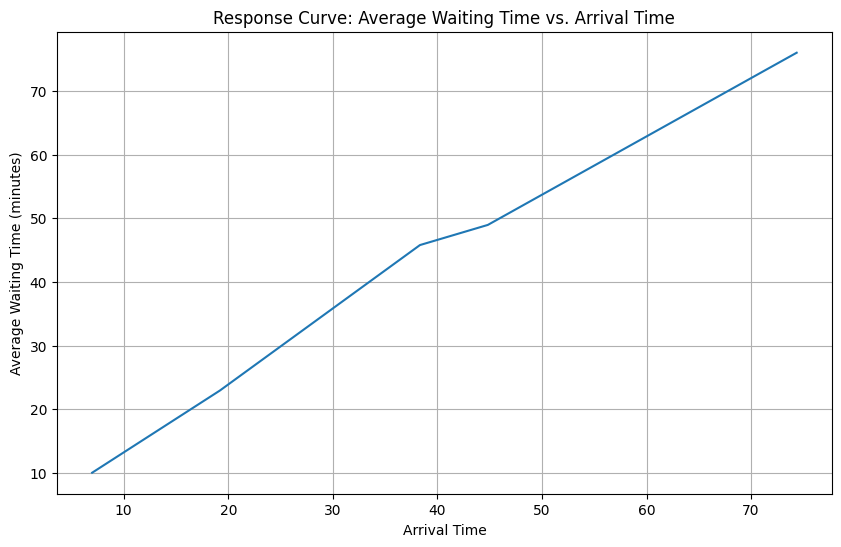

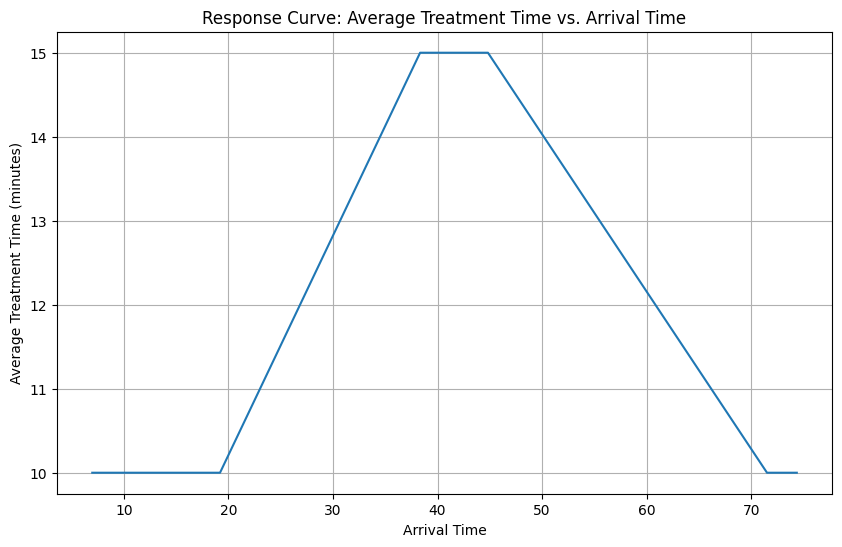

In [88]:
# Plot response curves

# Response curve for Average Waiting Time with respect to Service Type
service_types = df['Service'].unique()
avg_waiting_times = []
for service_type in service_types:
    avg_waiting_time = df[df['Service'] == service_type]['Wait Time (Mins)'].mean()
    avg_waiting_times.append(avg_waiting_time)

plt.figure(figsize=(10, 6))
plt.plot(service_types, avg_waiting_times, marker='o')
plt.xlabel('Service Type')
plt.ylabel('Average Waiting Time (minutes)')
plt.title('Response Curve: Average Waiting Time vs. Service Type')
plt.grid(True)
plt.show()

# Response curve for Average Treatment Time with respect to Service Type
avg_treatment_times = []
for service_type in service_types:
    avg_treatment_time = df[df['Service'] == service_type]['Service Time (Mins)'].mean()
    avg_treatment_times.append(avg_treatment_time)

plt.figure(figsize=(10, 6))
plt.plot(service_types, avg_treatment_times, marker='o')
plt.xlabel('Service Type')
plt.ylabel('Average Treatment Time (minutes)')
plt.title('Response Curve: Average Treatment Time vs. Service Type')
plt.grid(True)
plt.show()

# Response curve for Average Waiting Time with respect to Arrival Time
arrival_times = df['Arrival Time']
avg_waiting_times = []
for arrival_time in arrival_times:
    avg_waiting_time = df[df['Arrival Time'] == arrival_time]['Wait Time (Mins)'].mean()
    avg_waiting_times.append(avg_waiting_time)

plt.figure(figsize=(10, 6))
plt.plot(arrival_times, avg_waiting_times)
plt.xlabel('Arrival Time')
plt.ylabel('Average Waiting Time (minutes)')
plt.title('Response Curve: Average Waiting Time vs. Arrival Time')
plt.grid(True)
plt.show()

# Response curve for Average Treatment Time with respect to Arrival Time
avg_treatment_times = []
for arrival_time in arrival_times:
    avg_treatment_time = df[df['Arrival Time'] == arrival_time]['Service Time (Mins)'].mean()
    avg_treatment_times.append(avg_treatment_time)

plt.figure(figsize=(10, 6))
plt.plot(arrival_times, avg_treatment_times)
plt.xlabel('Arrival Time')
plt.ylabel('Average Treatment Time (minutes)')
plt.title('Response Curve: Average Treatment Time vs. Arrival Time')
plt.grid(True)
plt.show()


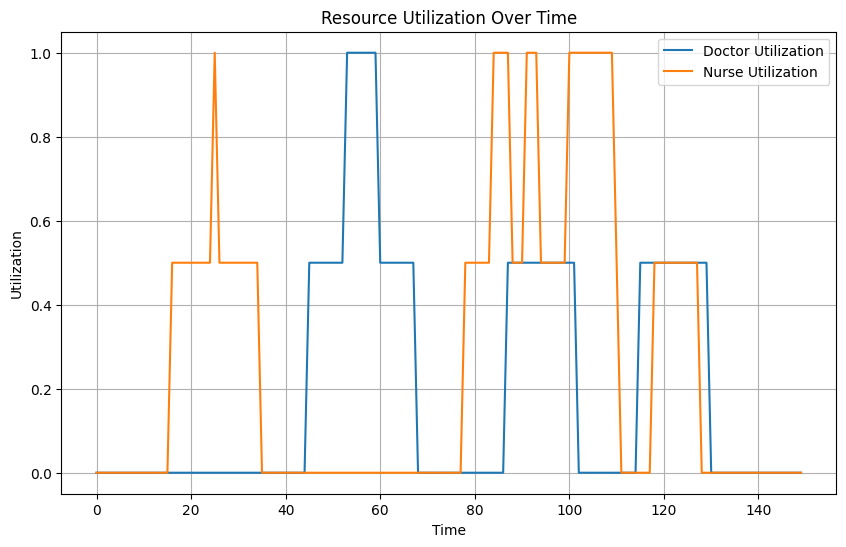

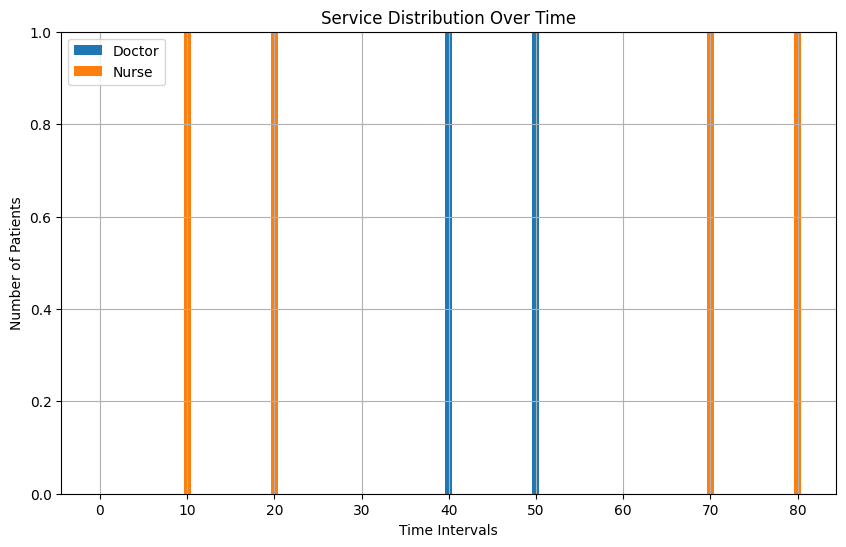

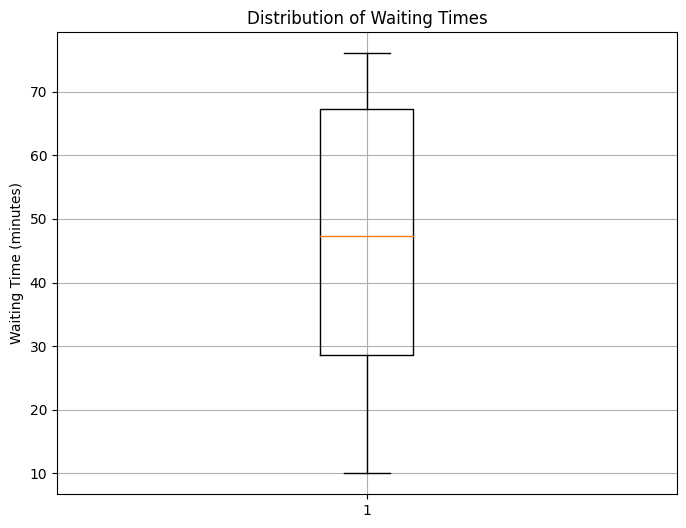

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


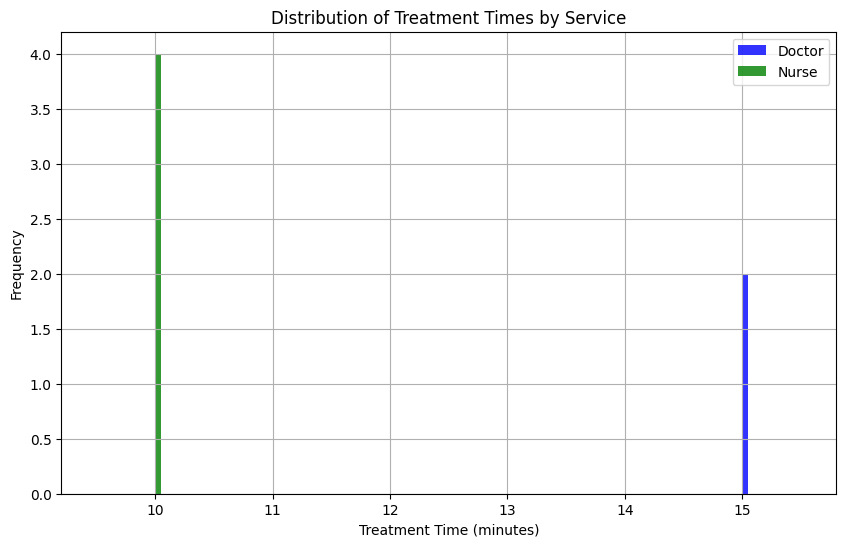

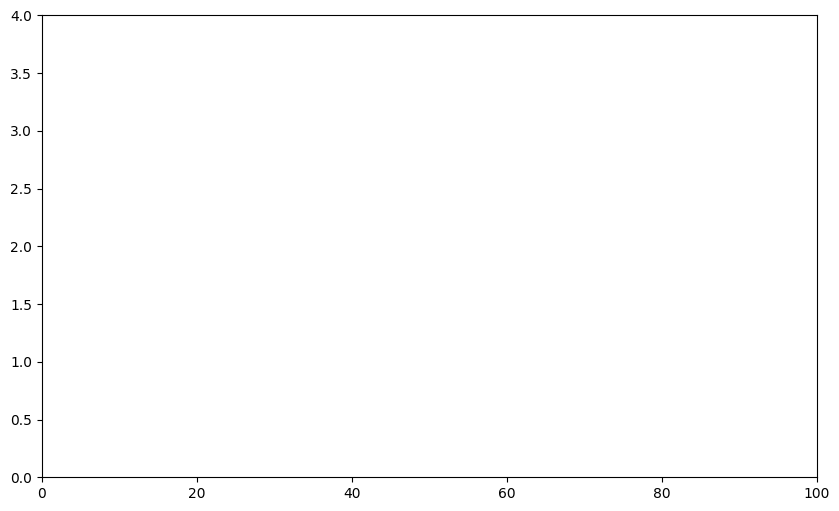

In [89]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# ...

# Line Chart of Resource Utilization
plt.figure(figsize=(10, 6))
plt.plot(range(len(utilization_doctors)), utilization_doctors, label='Doctor Utilization')
plt.plot(range(len(utilization_nurses)), utilization_nurses, label='Nurse Utilization')
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.title('Resource Utilization Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Stacked Bar Chart of Service Distribution
time_intervals = range(0, 100, 10)  # Customize the time intervals as needed
doctor_counts = df[df['Service'] == 'Doctor'].groupby(pd.cut(df['Service Start Time'], time_intervals)).size()
nurse_counts = df[df['Service'] == 'Nurse'].groupby(pd.cut(df['Service Start Time'], time_intervals)).size()

plt.figure(figsize=(10, 6))
plt.bar(time_intervals[:-1], doctor_counts, label='Doctor')
plt.bar(time_intervals[:-1], nurse_counts, bottom=doctor_counts, label='Nurse')
plt.xlabel('Time Intervals')
plt.ylabel('Number of Patients')
plt.title('Service Distribution Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Box Plot of Waiting Times
plt.figure(figsize=(8, 6))
plt.boxplot(df['Wait Time (Mins)'])
plt.ylabel('Waiting Time (minutes)')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()

# Histogram of Treatment Times by Service
plt.figure(figsize=(10, 6))
plt.hist(df[df['Service'] == 'Doctor']['Service Time (Mins)'], bins=20, alpha=0.8, color='blue', label='Doctor')
plt.hist(df[df['Service'] == 'Nurse']['Service Time (Mins)'], bins=20, alpha=0.8, color='green', label='Nurse')
plt.xlabel('Treatment Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Treatment Times by Service')
plt.legend()
plt.grid(True)
plt.show()

# Real-Time Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 100)  # Adjust the x-axis limits based on your simulation duration
ax.set_ylim(0, num_doctors + 2)  # Adjust the y-axis limits based on your resource capacity

# Function to update the real-time visualization
def update(frame):
    ax.clear()
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Patients')
    ax.set_title('Real-Time Patient Count')

    # Plot the current patient count
    patient_counts = df[(df['Arrival Time'] <= frame) & (df['Service Stop Time'] > frame)].groupby('Service Start Time').size()
    ax.plot(patient_counts.index, patient_counts.values)

    # Plot resource utilization
    ax.plot(range(frame + 1), utilization_doctors[:frame + 1], label='Doctor Utilization')
    ax.plot(range(frame + 1), utilization_nurses[:frame + 1], label='Nurse Utilization')

    ax.legend()
    ax.grid(True)

# Animate the real-time visualization
ani = animation.FuncAnimation(fig, update, frames=range(0, 100), interval=100)
plt.show()


# conclusion

The simulation model developed for analyzing patient flow and resource allocation in an outpatient setting has provided valuable insights for healthcare administrators. By simulating the operations of a medical facility and considering key factors such as patient arrivals, triage, and treatment, the model has allowed us to evaluate important performance metrics. The results emphasize the significance of efficient triage and resource allocation based on patient severity. The verification and validation processes have ensured the model's accuracy and reliability. This simulation-based approach offers a data-driven decision-making tool to optimize patient flow, reduce waiting times, and maximize resource utilization. By utilizing the insights gained, medical facilities can make informed operational changes and enhance the quality of care in outpatient settings.